In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'E:\Arti\Projects\Sept_2025\ml-project-end-2-end\data\Used_Car_Price_Prediction.csv')

In [4]:
df.head()

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,assured_buy,registered_city,registered_state,is_hot,rto,source,make,model,car_availability,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,True,delhi,delhi,True,dl6c,inperson_sale,maruti,swift,in_stock,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,True,noida,uttar pradesh,True,up16,inperson_sale,maruti,alto 800,in_stock,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,True,agra,uttar pradesh,True,up80,inperson_sale,hyundai,grand i10,in_stock,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,True,delhi,delhi,True,dl1c,inperson_sale,maruti,swift,in_stock,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,False,new delhi,delhi,True,dl12,inperson_sale,hyundai,grand i10,in_stock,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False


In [5]:
df.isna().sum()

car_name                  0
yr_mfr                    0
fuel_type                 0
kms_run                   0
sale_price                0
city                      0
times_viewed              0
body_type               103
transmission            556
variant                   0
assured_buy               0
registered_city          10
registered_state         10
is_hot                    0
rto                       0
source                  126
make                      0
model                     0
car_availability        620
total_owners              0
broker_quote              0
original_price         3280
car_rating                9
ad_created_on             1
fitness_certificate       8
emi_starts_from           0
booking_down_pymnt        0
reserved                  0
warranty_avail            0
dtype: int64

In [8]:
df['original_price'] = df.groupby(['make', 'model', 'yr_mfr'])['original_price'].transform(lambda x: x.fillna(x.median()))


In [9]:
def handle_missing_values(df, strategy="drop", fill_value=None):
    """Handle missing values: drop or fill."""
    if strategy == "drop":
        df = df.dropna()
    elif strategy == "fill":
        df = df.fillna(fill_value)
    elif strategy == "mean":
        df = df.fillna(df.mean(numeric_only=True))
    elif strategy == "median":
        df = df.fillna(df.median(numeric_only=True))
    elif strategy == "mode":
        for col in df.columns:
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

In [10]:
df = handle_missing_values(df, strategy="median")
df = handle_missing_values(df, strategy="mode")

In [11]:
df.duplicated().sum()

np.int64(1)

In [12]:
df = df.drop_duplicates()

In [80]:
X = df.drop(columns=['sale_price','ad_created_on','make','model','rto','variant', 'registered_city', 'registered_state'], axis=1)
y = df['sale_price']

In [81]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = ['car_name', 'fuel_type', 'city', 'body_type', 'transmission', 
                       'source' , 'car_availability']
ordinal_columns = ['car_rating']


In [82]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
le = LabelEncoder()
df['car_rating'] = le.fit_transform(df['car_rating'])

In [83]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [84]:
X[categorical_columns].nunique()

car_name            185
fuel_type             5
city                 13
body_type             5
transmission          2
source                3
car_availability      4
dtype: int64

In [85]:
print("unique source ",df['source'].unique())
# print("unique model ",df['model'].unique())
# print("unique variant ",df['variant'].unique()) 
# print("unique rto ",df['rto'].unique())
# print("unique ad_created_on",df['ad_created_on'].unique())


unique source  ['inperson_sale' 'online' 'customer_to_customer']


In [86]:
preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScaler', numeric_transformer, numeric_features),
        ('OneHotEncoder', categorical_transformer, categorical_columns),
    ])

In [87]:
preprocessor

,transformers,"[('StandardScaler', ...), ('OneHotEncoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [88]:
X = preprocessor.fit_transform(X)

In [89]:
X.shape

(7399, 226)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5919, 226), (1480, 226), (5919,), (1480,))

In [91]:
def evaluate_model(true, predicted):
    """Evaluate the model using RMSE and R² metrics."""
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    mae = sklearn.metrics.mean_absolute_error(true, predicted)
    return rmse, r2, mae

In [92]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Lasso" : Lasso(),
    "Ridge" : Ridge(),
    "ElasticNet" : ElasticNet()
}
model_list = []
r2_list = []

for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_rmse, train_r2, train_mae = evaluate_model(y_train, y_train_pred)
    test_rmse, test_r2 , test_mae= evaluate_model(y_test, y_test_pred)
    print(f"{list(models.keys())[i]} - Train RMSE: {train_rmse}, Train R²: {train_r2}, Train MAE: {train_mae}")
    print(f"{list(models.keys())[i]} - Test RMSE: {test_rmse}, Test R²: {test_r2}, Test MAE: {test_mae}")   
    model_list.append(list(models.keys())[i])
    r2_list.append(test_r2)

    print("-" * 50)

Linear Regression - Train RMSE: 0.45503359199896765, Train R²: 0.9999999999973231, Train MAE: 0.1763848556849376
Linear Regression - Test RMSE: 0.503995772564833, Test R²: 0.999999999997183, Test MAE: 0.18952197241073795
--------------------------------------------------
Random Forest - Train RMSE: 5377.855113015512, Train R²: 0.9996260947728235, Train MAE: 233.68265754350418
Random Forest - Test RMSE: 11114.204013998398, Test R²: 0.9986300869281446, Test MAE: 669.3455405405406
--------------------------------------------------
AdaBoost - Train RMSE: 34521.69186504819, Train R²: 0.984592666432039, Train MAE: 25623.90674484374
AdaBoost - Test RMSE: 36579.42492596515, Test R²: 0.9851608157291047, Test MAE: 27226.312591104743
--------------------------------------------------
Lasso - Train RMSE: 95.96364212583308, Train R²: 0.9999998809424925, Train MAE: 43.542831380311725
Lasso - Test RMSE: 156.73219072865143, Test R²: 0.9999997275714061, Test MAE: 44.78063459640697
---------------------

In [93]:
pd.DataFrame({'Model': model_list, 'R² Score': r2_list}).sort_values(by='R² Score', ascending=False)

,Model,R² Score
0,Linear Regression,1.000000
3,Lasso,1.000000
4,Ridge,0.999999
1,Random Forest,0.998630
2,AdaBoost,0.985161
5,ElasticNet,0.959514


In [94]:
linear_model = Lasso()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
score = r2_score(y_test, y_pred)
score

0.9999997275714061

Text(0, 0.5, 'Predicted Prices')

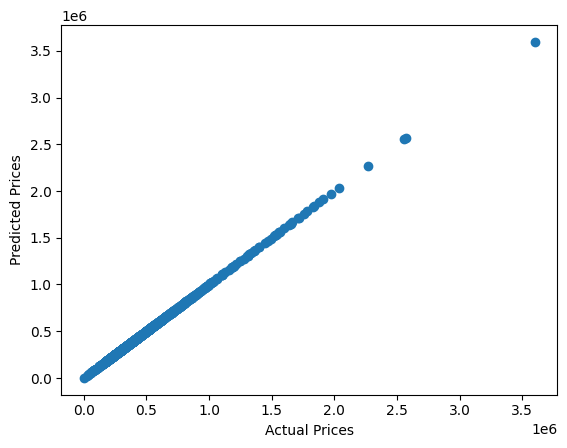

In [95]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

In [96]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(10)

,Actual,Predicted
2473,420000,420039.004176
6731,174000,174164.982192
2847,473699,473693.238537
169,238199,238232.753311
2036,485799,485710.816637
6353,219999,219991.515986
4500,230899,230872.193785
5837,421399,421395.949755
3491,331699,331656.337128
1302,372299,372264.164260
